100%|██████████| 3000/3000 [00:03<00:00, 797.60it/s]


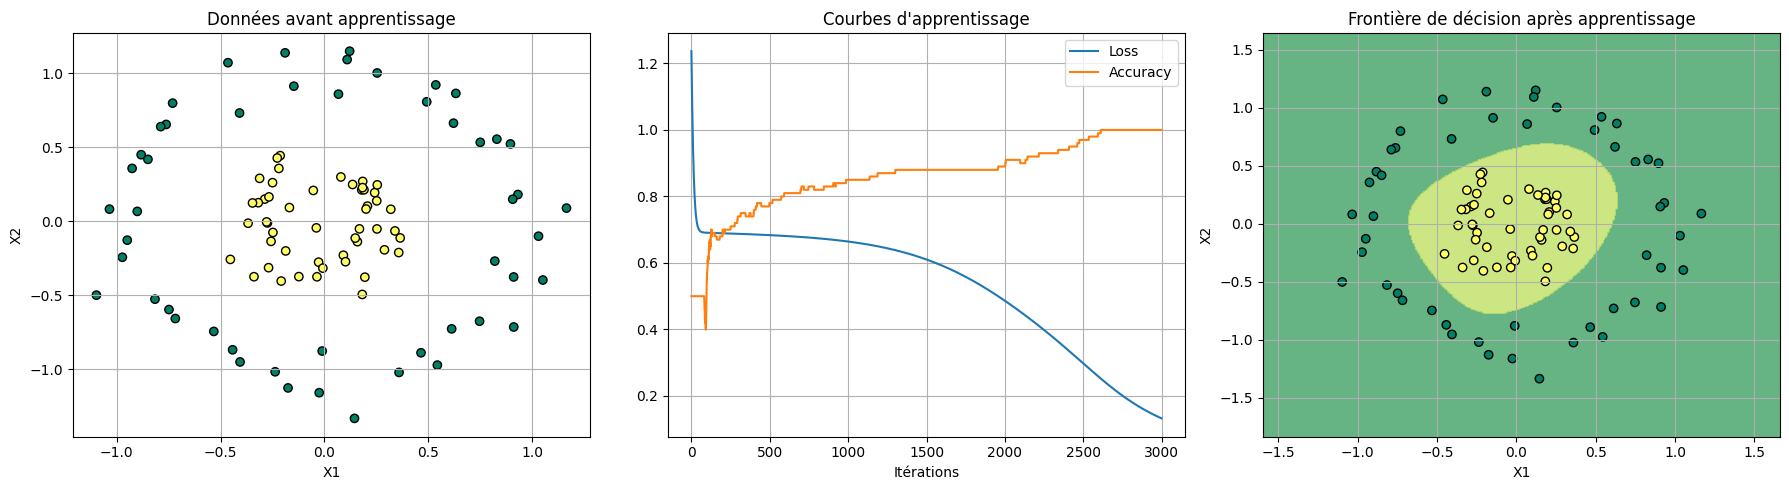

array([[1.23678615, 0.5       ],
       [1.20078412, 0.5       ],
       [1.16656353, 0.5       ],
       ...,
       [0.133099  , 1.        ],
       [0.13288708, 1.        ],
       [0.13267563, 1.        ]], shape=(3000, 2))

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm

def initialisation(dimensions):
    """
    Initialise les paramètres du réseau de neurones (poids et biais)
    
    Args:
        dimensions (list): Liste contenant le nombre de neurones par couche 
                          (ex: [2, 16, 16, 16, 1] pour 2 inputs, 3 couches cachées de 16 neurones et 1 output)
    
    Returns:
        dict: Dictionnaire contenant les matrices de poids (W) et vecteurs de biais (b)
    """
    parametres = {}
    C = len(dimensions)

    np.random.seed(1)  # Pour la reproductibilité

    for c in range(1, C):
        # Initialisation des poids avec une distribution normale
        parametres['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c - 1])
        # Initialisation des biais avec une distribution normale
        parametres['b' + str(c)] = np.random.randn(dimensions[c], 1)

    return parametres

def forward_propagation(X, parametres):
    """
    Propagation avant dans le réseau de neurones
    
    Args:
        X (ndarray): Matrice des données d'entrée
        parametres (dict): Paramètres du réseau (W et b)
    
    Returns:
        dict: Dictionnaire contenant toutes les activations (A) de chaque couche
    """
    activations = {'A0': X}  # A0 est l'input

    C = len(parametres) // 2  # Nombre de couches

    for c in range(1, C + 1):
        # Calcul du produit matriciel + biais
        Z = parametres['W' + str(c)].dot(activations['A' + str(c - 1)]) + parametres['b' + str(c)]
        # Application de la fonction d'activation sigmoïde
        activations['A' + str(c)] = 1 / (1 + np.exp(-Z))

    return activations

def back_propagation(y, parametres, activations):
    """
    Rétropropagation du gradient pour calculer les dérivées
    
    Args:
        y (ndarray): Vecteur des vraies valeurs
        parametres (dict): Paramètres du réseau
        activations (dict): Sorties de chaque couche
    
    Returns:
        dict: Dictionnaire contenant les gradients pour chaque paramètre
    """
    m = y.shape[1]  # Nombre d'exemples
    C = len(parametres) // 2  # Nombre de couches

    # Calcul du gradient initial (dérivée de la loss par rapport à Z de la dernière couche)
    dZ = activations['A' + str(C)] - y
    gradients = {}

    for c in reversed(range(1, C + 1)):
        # Gradient pour les poids
        gradients['dW' + str(c)] = 1/m * np.dot(dZ, activations['A' + str(c - 1)].T)
        # Gradient pour les biais
        gradients['db' + str(c)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
        if c > 1:
            # Propagation du gradient vers les couches précédentes
            dZ = np.dot(parametres['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (1 - activations['A' + str(c - 1)])

    return gradients

def update(gradients, parametres, learning_rate):
    """
    Mise à jour des paramètres selon la descente de gradient
    
    Args:
        gradients (dict): Gradients calculés
        parametres (dict): Paramètres actuels
        learning_rate (float): Taux d'apprentissage
    
    Returns:
        dict: Paramètres mis à jour
    """
    C = len(parametres) // 2

    for c in range(1, C + 1):
        # Mise à jour des poids
        parametres['W' + str(c)] = parametres['W' + str(c)] - learning_rate * gradients['dW' + str(c)]
        # Mise à jour des biais
        parametres['b' + str(c)] = parametres['b' + str(c)] - learning_rate * gradients['db' + str(c)]

    return parametres

def predict(X, parametres):
    """
    Prédiction des classes
    
    Args:
        X (ndarray): Données d'entrée
        parametres (dict): Paramètres du réseau
    
    Returns:
        ndarray: Prédictions binaires (0 ou 1)
    """
    activations = forward_propagation(X, parametres)
    C = len(parametres) // 2
    Af = activations['A' + str(C)]
    return Af >= 0.5  # Seuil à 0.5 pour la classification binaire

def deep_neural_network(X, y, hidden_layers=(4, 4), learning_rate=0.1, n_iter=3000):
    # Initialisation des paramètres
    dimensions = list(hidden_layers)
    dimensions.insert(0, X.shape[0])
    dimensions.append(y.shape[0])
    np.random.seed(1)
    parametres = initialisation(dimensions)

    training_history = np.zeros((int(n_iter), 2))
    C = len(parametres) // 2

    # Gradient descent
    for i in tqdm(range(n_iter)):
        activations = forward_propagation(X, parametres)
        gradients = back_propagation(y, parametres, activations)
        parametres = update(gradients, parametres, learning_rate)
        Af = activations['A' + str(C)]

        training_history[i, 0] = log_loss(y.flatten(), Af.flatten())
        y_pred = predict(X, parametres)
        training_history[i, 1] = accuracy_score(y.flatten(), y_pred.flatten())

    # Création de la figure globale
    plt.figure(figsize=(18, 5))
    
    # Sous-graphique 1: Données avant apprentissage
    plt.subplot(1, 3, 1)
    plt.scatter(X[0, :], X[1, :], c=y, cmap='summer', edgecolors='k')
    plt.title('Données avant apprentissage')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.grid(True)
    
    # Sous-graphique 2: Courbes d'apprentissage
    plt.subplot(1, 3, 2)
    plt.plot(training_history[:, 0], label='Loss', color='tab:blue')
    plt.plot(training_history[:, 1], label='Accuracy', color='tab:orange')
    plt.title('Courbes d\'apprentissage')
    plt.xlabel('Itérations')
    plt.legend()
    plt.grid(True)
    
    # Sous-graphique 3: Frontière de décision
    plt.subplot(1, 3, 3)
    x_min, x_max = X[0, :].min() - 0.5, X[0, :].max() + 0.5
    y_min, y_max = X[1, :].min() - 0.5, X[1, :].max() + 0.5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = predict(np.c_[xx.ravel(), yy.ravel()].T, parametres)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap='summer', alpha=0.8)
    plt.scatter(X[0, :], X[1, :], c=y, cmap='summer', edgecolors='k')
    plt.title('Frontière de décision après apprentissage')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    return training_history

# Génération des données
X, y = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=0)
X = X.T
y = y.reshape((1, y.shape[0]))

# Lancement de l'apprentissage
deep_neural_network(X, y)